# Deep Learning - MCH1
FS23, Manuel Schwarz

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Schritt 1: Auswahl Task / Datensatz

<div class="alert alert-block alert-info">
    
1. Mache Dir Gedanken, mit welchen Daten Du arbeiten möchtest und welcher Task gelernt werden soll.
    
2. Diskutiere die Idee mit dem Fachcoach.
    
</div>


### Daten und Task
Pytorch stellt einige Datensets zur Verfügung [datasets torch](https://pytorch.org/vision/main/datasets.html).
Verschiedene Kategorien stehen zur Auswahl:
- Image classification
- Image detection or segmentation
- Optical Flow
- Stereo Matching
- Image pairs
- Image captioning
- video classification
- Base classes for custom datasets


**Datenset**  
Eine beliebtes Dateset ist CIFAR10. Es beinhaltet Bilder von 10 Klassen (Flugzeuge, Katzen, Vögel, etc.), die Bilder kommen mit einer Auflösung von 32x32x3 pixel (rgb). Viele Tutorials starten mit diesem Datenset, das lässt darauf schliessen, dass der Rechenaufwand für die Hardware in einem vernümpftigen Rahmen liegt. Daher wird CIFAR10 als Datenset für die Challenge gewählt.

**Task**  
Anhand von CIFAR10 soll ein Modell erstellt werden, welches die Klasse eines Bildes korrekt klassifiziert.



![](cifar10.png)

# Schritt 2: Daten Kennenlernen

<div class="alert alert-block alert-info">
    
1. Mache Dich mit dem Datensatz vertraut, indem Du eine explorative Analyse der Features durchführst: z.B. Vergleich der Klassen pro Feature, Balanciertheit der Klassen. 
2. Führe ein geeignetes Preprocessing durch, z.B. Normalisierung der Daten.  
    
</div>

### 1. Explorative Datenanalyse
[Tutorial Dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [2]:
# Laden der Daten von CIFAR10
data_path = './data/'
train_data = torchvision.datasets.CIFAR10(data_path, train=True, download=True)

test_data = torchvision.datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


Datengrösse der Trainings- und Testdaten

In [3]:
print(f'Anzahl Trainingsdaten: {len(train_data)}\n'
      f'Anzahl Testdaten: {len(test_data)}')

Anzahl Trainingsdaten: 50000
Anzahl Testdaten: 10000


**Wie sind die Bilder im Datensatz gespeichert?**  
Die Bilder sind direkt auf dem Datenset via dem Index abrufbar. Ein Tupel mit dem Bild (RGB, 32x32 pixel) und dem Label (6).

In [4]:
img_0, label_0 = train_data[0]
img_0, label_0

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

In [5]:
# deffinieren der Labels CIFAR10
labels_cifar10_dict = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
labels_cifar10_list = list(labels_cifar10_dict.values())

**Visualisierung der Bilder**  
Die Bilder können mit matplotlib und imshow() direkt vom Dateset über den index dargestellt werden.


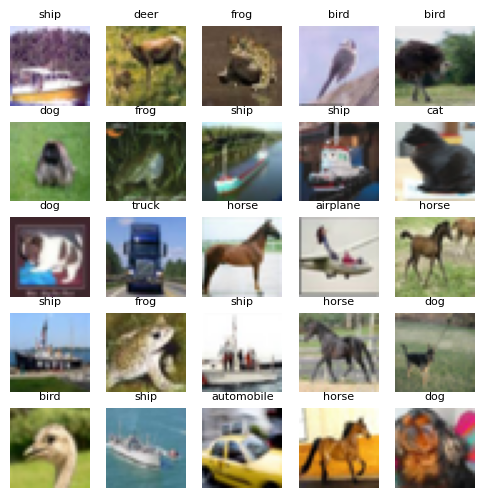

In [12]:
figure = plt.figure(figsize=(6,6))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_cifar10_list[label], fontsize=8)
    plt.axis('off')
    plt.imshow(img)
plt.show()

**Untersuchen der Verteilungen der Klassen**  
Folgend werden die Verteilungen der Klassen der Cifar10 Datensets auf den Trainings- und Testdaten geprüft.

In [7]:
train_target = train_data.targets
test_target = test_data.targets
print(f'Labels in Trainingsdaten: {len(train_target)}')
print(f'Labels in Testdaten: {len(test_target)}')

Labels in Trainingsdaten: 50000
Labels in Testdaten: 10000


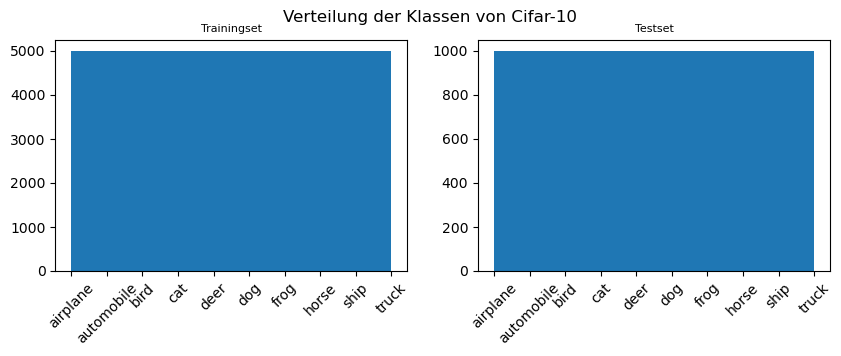

In [15]:
figure, ax = plt.subplots(1,2, figsize=(10, 3))

ax[0].hist(train_target)
ax[0].set_xticks(np.arange(10))
ax[0].set_xticklabels(labels_cifar10_list, rotation=45)
ax[0].set_title('Trainingset', fontsize=8)

ax[1].hist(test_target)
ax[1].set_xticks(np.arange(10))
ax[1].set_xticklabels(labels_cifar10_list, rotation=45)
ax[1].set_title('Testset', fontsize=8)

plt.suptitle('Verteilung der Klassen von Cifar-10', fontsize=12)
plt.show()

<div class="alert alert-block alert-success">
    
Das Trainingsset umfasst total 50'000 Bilder, davon sind jeweils 5000 Bilder jeder Klasse enthalten. Somit kann zum Beispiel eine Metrik wie'Accuracy' verwendet werden, um die Klassifikation der Modelle zu beurteilen und zu vergleichen. Die 10'000 Bilder in den Testdaten sind ebenfalls gleich verteilt.
    
</div>

### 2. Preprocessing der Daten  
Folgend werden die Daten in einem Preprocessing Schritt für die Modelle vorbereitet:

In [9]:
# function preprocessing
def preprocessing_cifar10(path='./data/', batch_size=32, 
                          norm_mean=(0.5, 0.5, 0.5), norm_std=(0.5, 0.5, 0.5), 
                          download=True, print_info=False):
    '''
    '''
    # transform tensor to normalized range [-1, 1]
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])
    if print_info: print('Normalized Tensor'), print(f'mean: {norm_mean} | std: {norm_std}')

    
    # CIFAR10: 50000 32x32 color images in 10 classes, with 5000 images per class
    train_dataset = torchvision.datasets.CIFAR10(root=path, train=True,
                                            download=download, transform=transform)

    test_dataset = torchvision.datasets.CIFAR10(root=path, train=False,
                                        download=download, transform=transform)
    if print_info: print('Data transformed')

    # dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    if print_info: print(f'Dataloader created with {batch_size=}')

    if print_info: print(f'Preprocessing done')    
    return train_dataset, test_dataset, train_loader, test_loader

In [17]:
# Hyper-parameters 
data_path = './data/'
batch_size = 32

train_dataset, test_dataset, train_loader, test_loader = preprocessing_cifar10(path=data_path, 
                                                                               batch_size=batch_size,
                                                                               norm_mean=(0.5, 0.5, 0.5), 
                                                                               norm_std=(0.5, 0.5, 0.5),
                                                                               download=False,  
                                                                               print_info=True)

Normalized Tensor
mean: (0.5, 0.5, 0.5) | std: (0.5, 0.5, 0.5)
Data transformed
Dataloader created with batch_size=32
Preprocessing done


# Schritt 3: Aufbau Modellierung  

<div class="alert alert-block alert-info">

1. Lege fest, wie (mit welchen Metriken) Du die Modelle evaluieren möchtest. Berücksichtige auch den Fehler in der Schätzung dieser Metriken.
2. Implementiere Basisfunktionalität, um Modelle zu trainieren und gegeneinander zu evaluieren. Wie sollen die Gewichte initialisiert werden?
    
</div>

# Schritt 4: Evaluation  

<div class="alert alert-block alert-warning">

Bei der Evaluation ist darauf zu achten, dass das Vorgehen stets möglichst reflektiert erfolgt und versucht wird, die Ergebnisse zu interpretieren. Am Schluss soll auch ein Fazit gezogen werden, darüber welche Variante am besten funktioniert.  

</div>

<div class="alert alert-block alert-info">

**1. Training mit SGD, ohne REG, ohne BN:**  
Untersuche verschiedene Modelle unterschiedlicher Komplexität, welche geeignet sein könnten, um das Klassifikationsproblem zu lösen. Verwende Stochastic Gradient Descent - ohne Beschleunigung, ohne Regularisierung (REG) und ohne Batchnorm (BN).  

a. Für jedes Modell mit gegebener Anzahl Layer und Units pro Layer führe ein sorgfältiges Hyper-Parameter-Tuning durch (Lernrate, Batch-Grösse). Achte stets darauf, dass das Training stabil läuft. Merke Dir bei jedem Training, den Loss, die Performance Metrik(en) inkl. Schätzfehler, die verwendete Anzahl Epochen, Lernrate und Batch-Grösse.

b. Variiere die Anzahl Layer und Anzahl Units pro Layer, um eine möglichst gute Performance zu erreichen. Falls auch CNNs (ohne Transfer-Learning) verwendet werden variiere auch Anzahl Filter, Kernel-Grösse, Stride, Padding.

c. Fasse die Ergebnisse zusammen in einem geeigneten Plot, bilde eine Synthese und folgere, welche Modell-Komplexität Dir am sinnvollsten erscheint.  

</div>


<div class="alert alert-block alert-info">

**2. Nutzen der Regularisierung**  
Ziehe nun verschiedene Regularisierungsmethoden bei den MLP Layern in Betracht:  
a. L1/L2 Weight Penalty  
b. Dropout

Evaluiere den Nutzen der Regularisierung, auch unter Berücksichtigung verschiedener Regularisierungsstärken. Beschreibe auch kurz, was allgemein das Ziel von Regularisierungsmethoden ist (Regularisierung im Allgemeinen, sowie auch Idee der einzelnen Methoden). Inwiefern wird dieses Ziel im gegebenen Fall erreicht?
    
</div>

<div class="alert alert-block alert-info">

**3. Nutzen von Batchnorm BN (ohne REG, mit SGD)**  
Evaluiere, ob Batchnorm etwas bringt. Beschreibe kurz, was die Idee von BN ist, wozu es helfen soll.
    
</div>    

<div class="alert alert-block alert-info">

**4. Nutzen von Adam (ohne BN, ohne / mit REG)**   
Evaluiere, ob Du mit Adam bessere Resultate erzielen kannst.
    
</div>    

# Tests

<div class="alert alert-block alert-info">
<b>Tipp:</b> Blaue Boxen .. 
</div>

<div class="alert alert-block alert-success">
<b>Erfolg:</b> Grüne Boxen (alert-success)
</div>

<div class="alert alert-block alert-danger">
<b>Warnung:</b> Rote Boxen (alert-danger)
</div>